<a href="https://colab.research.google.com/github/Ahmedfull02/MICROSOFT-SECURITY-INCIDENT-PREDICTION-USING-MULTI-AGENT-SYSTEM/blob/master/Notebook1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.Download necessary files

## 0.1 Downloading Dataset

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
microsoft_microsoft_security_incident_prediction_path = kagglehub.dataset_download('Microsoft/microsoft-security-incident-prediction')

print('Data source import complete.')


Data source import complete.


## 0.2 Downloading libraries

In [2]:
!pip install pandas matplotlib seaborn numpy scikit-learn catboost

# MICROSOFT SECURITY INCIDENT PREDICTION USING MULTI AGENT SYSTEM


# 1. Environment Setup

## 1.1. Imports

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## 1.2. Plot Styling

In [4]:
def style_and_save(
    ax,
    title='',
    xlabel='',
    ylabel='',
    filename='plot.png',
    title_pad=20,
    xlabel_pad=15,
    ylabel_pad=15,
    xtick_rotation=0,
    ytick_rotation=0,
    grid_axis='y',
    fontsize=11,
    show_legend=True
):
    ax.set_title(title, fontsize=12, fontweight='bold', pad=title_pad)
    ax.set_xlabel(xlabel, fontsize=10, fontweight='semibold', labelpad=xlabel_pad)
    ax.set_ylabel(ylabel, fontsize=10, fontweight='semibold', labelpad=ylabel_pad)
    ax.tick_params(axis='x', labelrotation=xtick_rotation, labelsize=fontsize)
    ax.tick_params(axis='y', labelrotation=ytick_rotation, labelsize=fontsize)
    ax.grid(axis=grid_axis, linestyle='--', alpha=0.5)
    if show_legend:
        ax.legend(loc='lower right', fontsize=10)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

In [5]:
def create_count_plot(
    df,
    column,
    title='',
    xlabel='',
    ylabel='',
    filename='count_plot.png',
    order=None,
    xtick_rotation=0,
    annotate_values=False,
    figsize=(8, 5)
):
    plt.figure(figsize=figsize)
    ax = sns.countplot(
        data=df[df[column].notnull()],
        x=column,
        order=order,
        edgecolor='gray',
        palette='pastel'
    )

    if annotate_values:
        for bar in ax.patches:
            height = bar.get_height()
            ax.annotate(f'{height:,}',
                        (bar.get_x() + bar.get_width() / 2., height),
                        ha='center', va='bottom', fontsize=10, fontweight='semibold')

    style_and_save(
        ax,
        title=title,
        xlabel=xlabel,
        ylabel=ylabel,
        filename=filename,
        xtick_rotation=xtick_rotation
    )


In [6]:
def create_stacked_barh(
    df,
    title='',
    xlabel='',
    ylabel='',
    filename='stacked_barh.png',
    colors=None,
    figsize=(10, 6),
    annotate_values=False
):
    if colors is None:
        colors = sns.color_palette('pastel')[:df.shape[1]]

    ax = df.plot(
        kind='barh',
        stacked=True,
        figsize=figsize,
        color=colors,
        edgecolor='gray'
    )

    if annotate_values:
        for container in ax.containers:
            for bar in container:
                width = bar.get_width()
                if width > 0:
                    ax.text(
                        bar.get_x() + width / 2,
                        bar.get_y() + bar.get_height() / 2,
                        f'{int(width):,}',
                        ha='center', va='center',
                        fontsize=9
                    )

    style_and_save(
        ax,
        title=title,
        xlabel=xlabel,
        ylabel=ylabel,
        filename=filename,
        grid_axis='x'
    )

## 1.3. Dataset Loading

In [7]:
# DO NOT IMPORT DATASET WITH THIS LINE IF YOU HAVE LIMITED RAM IN COLAB
#df = pd.read_csv('/kaggle/input/microsoft-security-incident-prediction/GUIDE_Train.csv')

In [ ]:
# RUN THIS INSTEAD
chunks = pd.read_csv('/kaggle/input/microsoft-security-incident-prediction/GUIDE_Train.csv',chunksize=10000)
df = pd.concat(chunks)

## 2. Exploratory Data Analysis

### 2.1. Dataset Definition

#### 2.1.1. Columns

In [ ]:
df.info()

Here is the description for the features, as mentioned in the source paper titled [**AI-Driven Guided Response for Security Operation Centers with Microsoft Copilot for Security**](https://arxiv.org/pdf/2407.09017).
## 2.1.1. Variables (Columns)

| Feature               | Description |
|-----------------------|------------|
| Id                    | Unique identifier for each OrgId-IncidentId combination, ensuring global uniqueness of each record |
| OrgId                 | Identifier for the organization where the incident or alert originated (used to separate data across tenants) |
| IncidentId            | Unique identifier assigned by the organization to each tracked security incident |
| AlertId               | Unique identifier for an individual alert generated by a detection system |
| Timestamp             | Date and time when the alert was created (UTC format) |
| DetectorId            | Identifier of the detection engine that generated the alert |
| AlertTitle            | Descriptive title summarizing the nature of the alert |
| Category              | Broad classification of the alert (type of detected threat) |
| MitreTechniques       | List of MITRE ATT&CK techniques associated with the alert |
| IncidentGrade         | Severity level assigned by the Security Operations Center |
| ActionGrouped         | High-level description of the remediation action taken |
| ActionGranular        | Detailed description of the specific remediation measures |
| EntityType            | Type of entity involved in the alert |
| EvidenceRole          | Role of the evidence within the investigation |
| Roles                 | Additional metadata labels for entity roles in the alert |
| DeviceId              | Unique identifier for the device involved |
| DeviceName            | Human-readable name of the device involved |
| Sha256                | SHA-256 hash of the file involved |
| IpAddress             | IP address associated with the alert |
| Url                   | URL involved in the alert |
| AccountSid            | Identifier for an on-premises account linked to the alert |
| AccountUpn            | User Principal Name of the account involved |
| AccountObjectId       | Entra ID object identifier for the user/account |
| AccountName           | Username of the on-premises account involved |
| NetworkMessageId      | Organization-level unique identifier for email messages |
| EmailClusterId        | Identifier for a cluster of related email messages |
| RegistryKey           | Windows registry key involved |
| RegistryValueName     | Name of the registry value that was modified/accessed |
| RegistryValueData     | Data stored in the registry value at alert time |
| ApplicationId         | Unique identifier for an application involved |
| ApplicationName       | Name of the application involved |
| OAuthApplicationId    | Identifier for the OAuth application involved |
| ThreatFamily          | Name of the detected malware family |
| FileName              | Name of the file involved |
| FolderPath            | Path where the file was located at alert time |
| ResourceIdName        | Name of the Azure resource involved |
| ResourceType          | Type of Azure resource involved |
| OSFamily              | Operating system family of the device |
| OSVersion             | Operating system version of the device |
| AntispamDirection     | Direction of email traffic processed by antispam |
| SuspicionLevel        | Assigned level of suspicion for the alert/entity |
| LastVerdict           | Final classification after review |
| CountryCode           | ISO country code of the alert's geographic location |
| State                 | State/province name of the alert evidence location |
| City                  | City name of the alert evidence location |

### 2.1.2. Entries

In [ ]:
total_rows = len(df)
print(f"{total_rows:,}")

## 2.2. Target Variable Selection

In [ ]:
candidates_var = ['IncidentGrade', 'SuspicionLevel', 'LastVerdict', 'Category']

for col in candidates_var:
    print(f"\n📌 Variable: {col}")
    print("-" * 40)
    print(f"Unique values:\n{df[col].unique()}")
    print(f"\nnumber of NULL values: {df[col].isnull().sum()} de {len(df)} registros totales")
    print("=" * 60)

In [ ]:
vars = ['IncidentGrade', 'SuspicionLevel', 'LastVerdict', 'Category']

# Calculation of null and non-null values

data = {
    'Not Null': [df[var].notnull().sum() for var in vars],
    'Null': [df[var].isnull().sum() for var in vars]
}

# DataFrame creation

df_nulls = pd.DataFrame(data, index=vars)

# Plot

create_stacked_barh(
    df=df_nulls,
    title='Null vs Non-Null Values by Candidate Variable',
    xlabel='Record Count',
    ylabel='Variable',
    filename='null_values_by_variable.png',
    annotate_values=False
)


## 2.3. Target Variable Distribution

/tmp/ipython-input-5-1792266130.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
/tmp/ipython-input-4-2575828824.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right', fontsize=10)


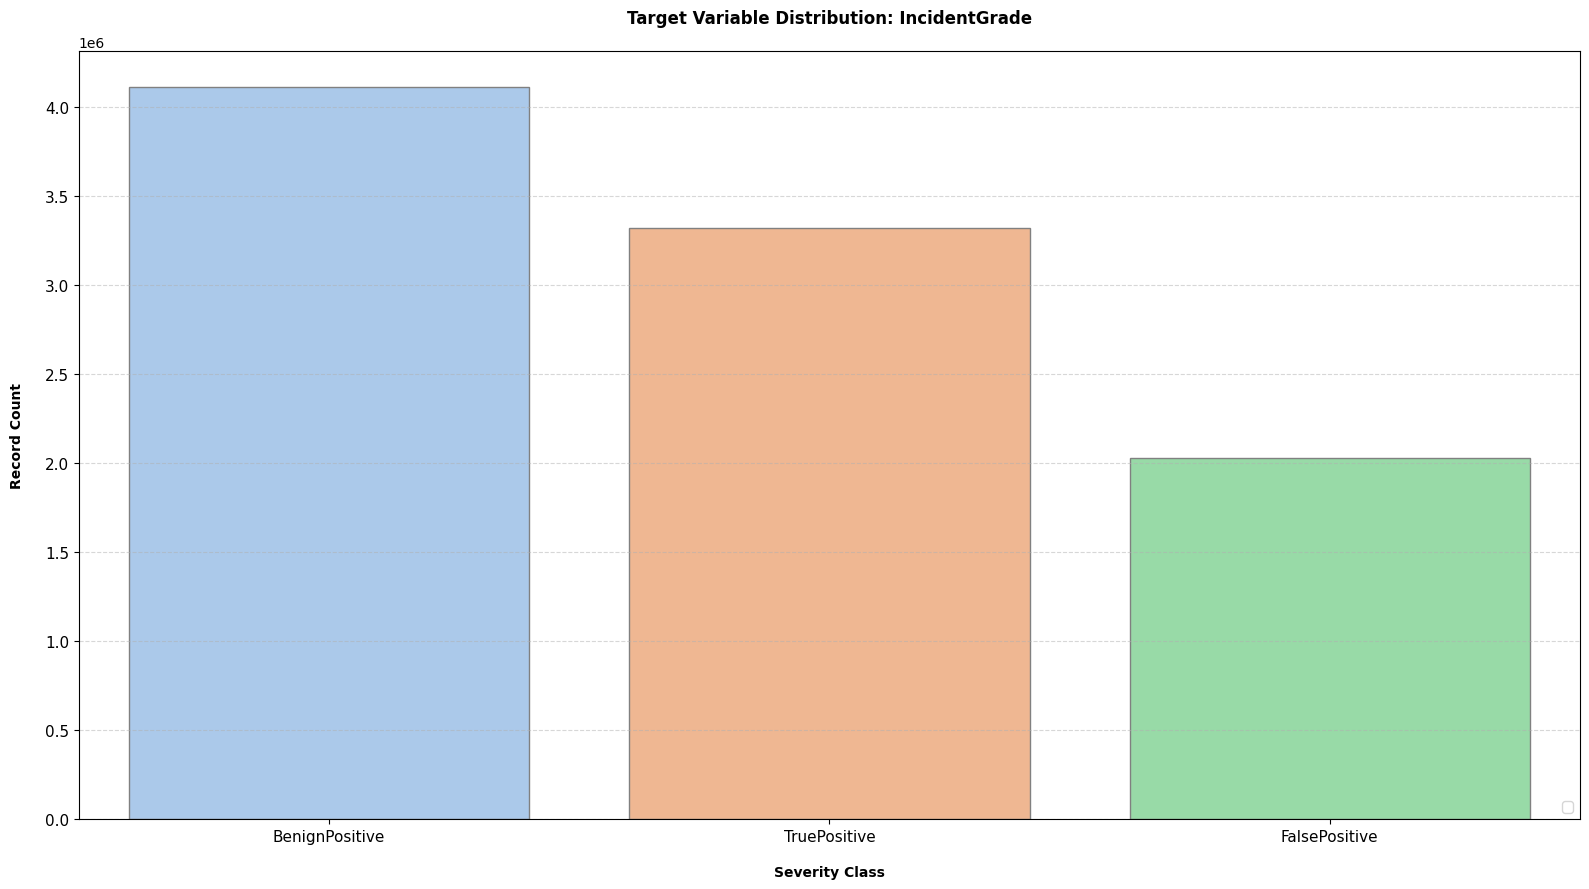

In [13]:
create_count_plot(
    df=df,
    column='IncidentGrade',
    title='Target Variable Distribution: IncidentGrade',
    xlabel='Severity Class',
    ylabel='Record Count',
    filename='target_variable_distribution.png',
    order=df['IncidentGrade'].value_counts().index,
    figsize=(16,9)
)

## 2.4. Missing Values Visualization

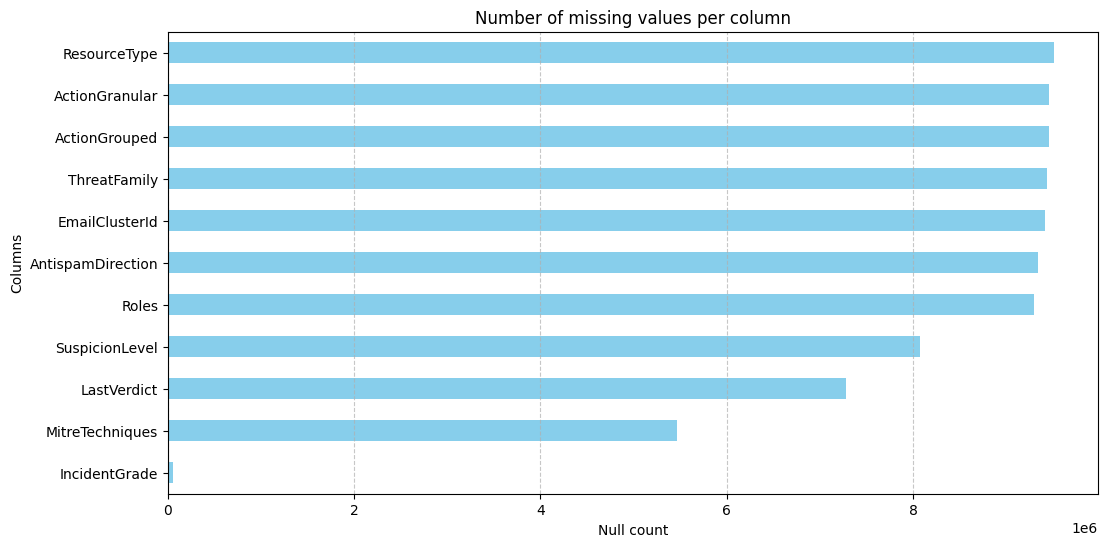

In [14]:
# Count null values per column

missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values = missing_values.sort_values()

# Visualize

plt.figure(figsize=(12, 6))
missing_values.plot(kind='barh', color='skyblue')
plt.title('Number of missing values per column')
plt.xlabel('Null count')
plt.ylabel('Columns')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# 3. Preprocessing

## 3.1. Data Cleaning

### 3.1.1. Dropping Rows/Columns with Null Values

In [15]:
def viewRemainingColumns():
    numeric_columns = df.select_dtypes(include=['float64', 'int64', 'int32']).columns
    string_columns = df.select_dtypes(include=['object']).columns

    # Print column names
    print("Numeric columns:")
    print(numeric_columns)
    print(f"Total of Numeric columns: {len(numeric_columns)}\n")

    print("String columns:")
    print(string_columns)
    print(f"Total of String columns: {len(string_columns)}")

In [16]:
# Drop columns with more than 70% null values

columns_with_high_null = []

for column in df.columns:
    if df[column].isnull().sum() / total_rows > 0.7:
        columns_with_high_null.append(column)

print("Columns with >70% null values:", columns_with_high_null)
print(f"Total columns to drop: {len(columns_with_high_null)}\n")

df = df.drop(columns=columns_with_high_null)

Columns with >70% null values: ['ActionGrouped', 'ActionGranular', 'EmailClusterId', 'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection', 'SuspicionLevel', 'LastVerdict']
Total columns to drop: 9



In [ ]:
viewRemainingColumns()

In [ ]:
# Drop rows with null IncidentGrade to avoid fabricating target class values

df = df.dropna(subset=['IncidentGrade'])

total_rows_after_delete = len(df)
print(f"{round((total_rows_after_delete / total_rows * 100), 2)}%")

In [ ]:
# Update total row count after cleaning
total_rows = total_rows_after_delete
print(f"Updated dataset contains {total_rows:,} records")

### 3.1.2. Null value Removing

In [ ]:
# Remove missing MitreTechniques values with the mode (most frequent value)

print(df['MitreTechniques'].isnull().sum())

mode = df['MitreTechniques'].mode()[0]

df.fillna({'MitreTechniques': mode}, inplace=True)

print(df['MitreTechniques'].isnull().sum())

### 3.1.3. Remove irrelevant columns

In [ ]:
def format_percentage(num_uniques, total_rows):
    percentage = (num_uniques / total_rows) * 100
    rounded = round(percentage, 2)
    return "<0.01%" if rounded == 0.0 and num_uniques > 0 else f"{rounded:.2f}%"

In [ ]:
def get_uniques_list(cols):
    return sorted(
        [(col, df[col].nunique()) for col in cols],
        key=lambda x: x[1],
        reverse=True)


In [ ]:
# Check uniqueness of ID records

numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
string_cols = df.select_dtypes(include=['object']).columns

numeric_uniques = get_uniques_list(numeric_cols)
string_uniques = get_uniques_list(string_cols)

print("\nUnique values for each numeric column:\n")
print(f"{'Column':<30} {'Unique':<10} {'% of total'}")
print("-" * 55)
for col, num_uniques in numeric_uniques:
    percentage_str = format_percentage(num_uniques, total_rows)
    print(f"{col:<30} {num_uniques:<10} {percentage_str}")

print("\n\nUnique values for each categorical column:\n")
print(f"{'Column':<30} {'Unique':<10} {'% of total'}")
print("-" * 55)
for col, num_uniques in string_uniques:
    percentage_str = format_percentage(num_uniques, total_rows)
    print(f"{col:<30} {num_uniques:<10} {percentage_str}")


In [ ]:
# List of irrelevant columns for the correlation matrix
# Selection based on previous output (>3%)
irrelevant_columns = ['AlertId', 'Id', 'AccountUpn', 'IncidentId', 'NetworkMessageId',
                     'AccountName', 'AccountSid', 'AccountObjectId', 'IpAddress']

df = df.drop(columns=irrelevant_columns)

viewRemainingColumns()

## 3.2. Codificación de variables categóricas

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Select object-type columns excluding 'Timestamp'
encode_label = df.select_dtypes([object]).columns
encode_label = [col for col in encode_label if col != 'Timestamp']

print(encode_label)

# Dictionary to store fitted encoders
label_encoders = {}

# Apply LabelEncoder to each categorical column (excluding 'Timestamp')
for col in encode_label:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


### 3.3. Date/Time Processing

#### 3.3.1. DateTime Conversion

In [ ]:
### 3.3.2. Date Aggregation

unique_lengths = set(df['Timestamp'].map(len))
print(unique_lengths)

df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month
df['Day'] = df['Timestamp'].dt.day
df['Hour'] = df['Timestamp'].dt.hour
df['Minute'] = df['Timestamp'].dt.minute
df['Second'] = df['Timestamp'].dt.second
df['Weekday'] = df['Timestamp'].dt.weekday  # 0 = Monday, 6 = Sunday

### 3.3.2. Date Aggregation

In [ ]:
## Day: 0 | Night: 1

def asign_period(hour):
    if 7 <= hour < 19:
        return 0
    else:
        return 1


## Spring: 0 | Summer: 1 | Autumn: 2 | Winter: 3

def asign_season(month):
    if 3 <= month <= 5:
        return 0
    elif 6 <= month <= 8:
        return 1
    elif 9 <= month <= 11:
        return 2
    else:
        return 3


## holidays Period: 0 | Non holidays Period: 1

def asign_holidays(weekday):
    if 0 <= weekday < 5:
        return 0
    else:
        return 1

In [ ]:
# for time slot
df['Period'] = df['Hour'].apply(asign_period)

# For season
df['Season'] = df['Month'].apply(asign_season)

# For Holiday
df['Holiday'] = df['Weekday'].apply(asign_holidays)

In [ ]:
viewRemainingColumns()

### 3.3.3. Removal of Date Attributes

In [ ]:
print("Unique values for the year:", len(df['Year'].unique()))  # This variable can be removed

In [ ]:
df = df.drop(columns=['Year', 'Month', 'Weekday', 'Day', 'Hour', 'Minute', 'Second'])
df = df.drop(columns=['Timestamp'])

In [ ]:
viewRemainingColumns()

## 3.4. Correlation Analysis

### 3.4.1. Correlation Matrix

In [ ]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Visualize the correlation matrix
plt.figure(figsize=(18, 16))
ax = sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Matriz de correlación")

style_and_save(
    ax=ax,
    title='Matriz de Correlación',
    xlabel='Variables',
    ylabel='Variables',
    filename='matriz_de_correlacion.png',
    xtick_rotation=45,
    ytick_rotation=45
)

### 3.4.2. Eliminación de variables muy correlacionadas

In [ ]:
threshold = 0.7

abs_corr = correlation_matrix.abs()
high_corr_pairs = []

num_cols = abs_corr.shape[1]

for i in range(num_cols):
    for j in range(i + 1, num_cols):
        corr_value = abs_corr.iloc[i, j]
        if corr_value > threshold:
            high_corr_pairs.append((abs_corr.columns[i], abs_corr.columns[j], corr_value))

if high_corr_pairs:
    print(f"Pairs of variables with correlation greater than {threshold}:")
    print(f"{'Variable 1':<20} {'Variable 2':<20} {'Correlation'}")
    print("-" * 55)
    for col1, col2, corr_value in high_corr_pairs:
        print(f"{col1:<20} {col2:<20} {corr_value:.2f}")
else:
    print(f"There are no pairs with correlation greater than {threshold}")

In [ ]:
df = df.drop(columns=['Sha256', 'FileName', 'RegistryValueData', 'ApplicationName', 'OSVersion', 'City', 'State'])

In [ ]:
viewRemainingColumns()

## 3.5. Manual filter

In [ ]:
df = df.drop(columns=['OrgId', 'DetectorId', 'DeviceId', 'ApplicationId', 'OAuthApplicationId'])

In [ ]:
viewRemainingColumns()

## 3.6. Anomaly Detection
### 3.5.1. Remove Outliers
### 3.5.2. PCA

# 4. Training

## 4.1. Training Preparation

### 4.1.1. Imports

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

### 4.1.2. Encoding of the Target Variable

In [ ]:
label_map = {
    'BenignPositive': 0,
    'FalsePositive': 1,
    'TruePositive': 2
}

### 4.1.3. Data Splitting

In [ ]:
# X e y
X = df.drop(columns=['IncidentGrade'])
y = df['IncidentGrade']

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(
#    X, y, test_size=0.2, random_state=42, stratify=y
#)

## 4.2. Modeling

In [ ]:
models = {
    'CatBoost': CatBoostClassifier(verbose=0),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'RandomForest': RandomForestClassifier()
}

## 4.3. Training

In [ ]:
#for name, model in models.items():
#    print(f"\nEntrenando {name}...")
#    model.fit(X_train, y_train)
#    y_pred = model.predict(X_test)
#    print(f"\n{name} Classification Report:")
#    print(classification_report(y_test, y_pred))

## 4.4. Class Balancing

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import CondensedNearestNeighbour
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from imblearn.under_sampling import ClusterCentroids
from sklearn.cluster import MiniBatchKMeans
from sklearn.utils import resample
import time

In [ ]:
target_size = y.value_counts()[1]

In [ ]:
# 1. Undersample clase 0 (BenignPositive)
rus_0 = RandomUnderSampler(sampling_strategy={0: target_size}, random_state=42)
X_rus_0, y_rus_0 = rus_0.fit_resample(X, y)

In [ ]:
# 2. Oversample clase 1 (FalsePositive) based on the result of the previous step
# smote = SMOTE(sampling_strategy={1: target_size}, random_state=42)
# X_balanced, y_balanced = smote.fit_resample(X_rus, y_rus)

In [ ]:
# 2. Undersample clase 2 (BenignPositive)
rus_2 = RandomUnderSampler(sampling_strategy={2: target_size}, random_state=42)
X_rus_final, y_rus_final = rus_2.fit_resample(X_rus_0, y_rus_0)

In [ ]:
# 3.  Shuffle Data
X_balanced, y_balanced = shuffle(X_rus_final, y_rus_final, random_state=42)

In [ ]:
# 4. Verify the Result
print("Distribution after undersampling:")
print(y_balanced.value_counts())

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

In [ ]:
#from imblearn.under_sampling import TomekLinks

#tl = TomekLinks(sampling_strategy='auto')  # Auto applies to all classes
#X_tomek, y_tomek = tl.fit_resample(X, y)

#  Verify Sizes
#from collections import Counter
#print("Original distribution:", Counter(y))
#print("Distribution after Tomek:", Counter(y_tomek))

In [ ]:
# def extract_representatives_kmeans(X, y, n_samples_per_class=100):
#     X_rep = []
#     y_rep = []

#     for label in np.unique(y):
#         X_class = X[y == label]
#         y_class = y[y == label]

#         n_clusters = min(n_samples_per_class, len(X_class))

#         kmeans = KMeans(n_clusters=n_clusters, random_state=42)
#         kmeans.fit(X_class)
#         closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X_class)

#         X_selected = X_class.iloc[closest]
#         y_selected = y_class.iloc[closest]

#         X_rep.append(X_selected)
#         y_rep.append(y_selected)

#     X_balanced_kmeans = pd.concat(X_rep)
#     y_balanced_kmeans = pd.concat(y_rep)

#     return X_balanced_kmeans, y_balanced_kmeans

In [ ]:
# Apply balancing by representativity
#X_kmeans, y_kmeans = extract_representatives_kmeans(X, y, n_samples_per_class=100)

# Split for training
#X_train_km, X_test_km, y_train_km, y_test_km = train_test_split(
#    X_kmeans, y_kmeans, test_size=0.2, stratify=y_kmeans, random_state=42
#)

# Train and evaluate models
#for name, model in models.items():
 #   print(f"\n{name} with representative KMeans:")
 #  model.fit(X_train_km, y_train_km)
 # y_pred_km = model.predict(X_test_km)
 #print(classification_report(y_test_km, y_pred_km))

In [ ]:
# df_full = pd.concat([X, y], axis=1)

# df_sampled = df_full.groupby('IncidentGrade').apply(
#     lambda g: g.sample(n=min(len(g), 100000), random_state=42)
# ).reset_index(drop=True)

# X_sampled = df_sampled.drop(columns='IncidentGrade')
# y_sampled = df_sampled['IncidentGrade']

# mini_kmeans = MiniBatchKMeans(n_init=10, batch_size=1024, max_iter=100, random_state=42)

# cc = ClusterCentroids(estimator=mini_kmeans, random_state=42)

# X_cc, y_cc = cc.fit_resample(X_sampled, y_sampled)

# print("\nClass distribution after ClusterCentroids:")
# print(pd.Series(y_cc).value_counts())

# # Dividing to train and test
# X_train_cc, X_test_cc, y_train_cc, y_test_cc = train_test_split(
#     X_cc, y_cc, test_size=0.2, stratify=y_cc, random_state=42
# )

In [ ]:
# print("\nModels after balancing:")

# for name, model in models.items():
#     print(f"\n{name} with ClusterCentroids:")
#     model.fit(X_train_cc, y_train_cc)
#     y_pred_cnn = model.predict(X_test_cc)
#     print(f"\n{name} Classification Report:")
#     print(classification_report(y_test_cc, y_pred_cc))

In [ ]:
# for name, model in models.items():
#    print(f"\nTraining {name}...")
#    model.fit(X_train, y_train)
#    y_pred = model.predict(X_test)
#    print(f"\n{name} Classification Report:")
#    print(classification_report(y_test, y_pred))

## 4.5. Ensemble and Stacking

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
ensemble = VotingClassifier(
    estimators=[
        ('catboost', models['CatBoost']),
        ('xgboost', models['XGBoost']),
        ('randomforest', models['RandomForest'])
    ],
    voting='soft'
)

ensemble.fit(X_train, y_train)

y_pred_ensemble = ensemble.predict(X_test)
print("\nEnsemble with Soft Voting on balanced data:")
print(classification_report(y_test, y_pred_ensemble))

In [ ]:
# stacking_clf = StackingClassifier(
#     estimators=[
#         ('catboost', models['CatBoost']),
#         ('xgboost', models['XGBoost']),
#         ('randomforest', models['RandomForest'])
#     ],
#     final_estimator=LogisticRegression(max_iter=1000),
#     cv=5,
#     n_jobs=-1,
#     passthrough=False
# )

# stacking_clf.fit(X_train, y_train)

# y_pred_stack = stacking_clf.predict(X_test)
print("\nEnsemble with Soft Voting on balanced data:")
# print(classification_report(y_test, y_pred_stack))

# 5. Evaluation

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
import numpy as np

In [ ]:
# Binarize labels for multiclass classification
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# Get probabilities
y_proba_ensemble = ensemble.predict_proba(X_test)
# y_proba_stack = stacking_clf.predict_proba(X_test)

## 4.1. ROC - AUC Curve


In [ ]:
# Calculate ROC curves and AUC for each class
fpr_ens, tpr_ens, fpr_stack, tpr_stack, auc_ens, auc_stack = {}, {}, {}, {}, {}, {}
for i in range(n_classes):
    fpr_ens[i], tpr_ens[i], _ = roc_curve(y_test_bin[:, i], y_proba_ensemble[:, i])
    # fpr_stack[i], tpr_stack[i], _ = roc_curve(y_test_bin[:, i], y_proba_stack[:, i])
    auc_ens[i] = auc(fpr_ens[i], tpr_ens[i])
    # auc_stack[i] = auc(fpr_stack[i], tpr_stack[i])

In [ ]:
# Plot ROC
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr_ens[i], tpr_ens[i], '--', label=f'Ensemble - Clase {classes[i]} (AUC = {auc_ens[i]:.2f})')
    # plt.plot(fpr_stack[i], tpr_stack[i], '-', label=f'Stacking - Clase {classes[i]} (AUC = {auc_stack[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.title('ROC Curve - Ensemble')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

## 4.2. Confusion matrix

In [ ]:
# Matriz de confusión - Ensemble
cm_ens = confusion_matrix(y_test, y_pred_ensemble)
disp_ens = ConfusionMatrixDisplay(confusion_matrix=cm_ens, display_labels=classes)
disp_ens.plot(cmap=plt.cm.Blues)
plt.title("Confusion matrix - Ensemble")
plt.show()

# Confusion matrix - Stacking
# cm_stack = confusion_matrix(y_test, y_pred_stack)
# disp_stack = ConfusionMatrixDisplay(confusion_matrix=cm_stack, display_labels=classes)
# disp_stack.plot(cmap=plt.cm.Oranges)
# plt.title("Confusion matrix - Stacking")
# plt.show()

## 4.2. Precision, Recall, F1-Score

## 4.4. Distribution of Predicted Probabilities by Class

In [ ]:
import seaborn as sns
import pandas as pd

In [ ]:
# Create DataFrame with predicted probabilities from the ensemble and stacking
ensemble_proba_df = pd.DataFrame(y_proba_ensemble, columns=[f'Clase {c}' for c in classes])
# stacking_proba_df = pd.DataFrame(y_proba_stack, columns=[f'Clase {c}' for c in classes])

# Add true labels to distinguish the classes
ensemble_proba_df['Clase verdadera'] = y_test.values
# stacking_proba_df['Clase verdadera'] = y_test.values

In [ ]:
# Plots by class
for c in classes:
    class_str = f'Class {c}'
    plt.figure(figsize=(10, 4))

    # Ensemble
    sns.kdeplot(
        data=ensemble_proba_df, x=class_str, hue='True Class',
        common_norm=False, fill=True, alpha=0.4, linewidth=1.5,
        palette='tab10', label='Ensemble'
    )
    plt.title(f'Probability Distribution - Ensemble ({class_str})')
    plt.xlabel('Estimated Probability')
    plt.ylabel('Density')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # # Stacking
    # plt.figure(figsize=(10, 4))
    # sns.kdeplot(
    #     data=stacking_proba_df, x=class_str, hue='True Class',
    #     common_norm=False, fill=True, alpha=0.4, linewidth=1.5,
    #     palette='tab10', label='Stacking'
    # )
    # plt.title(f'Probability Distribution - Stacking ({class_str})')
    # plt.xlabel('Estimated Probability')
    # plt.ylabel('Density')
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()
